In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os
datadir = 'data'

# Location variable.

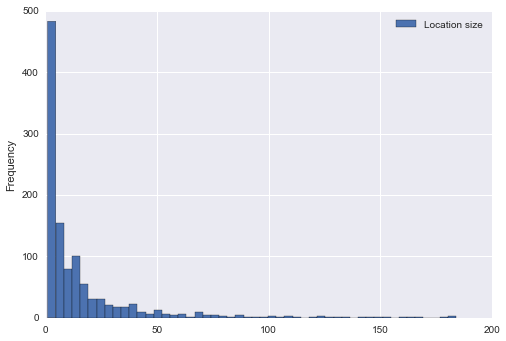

In [2]:
# load Location, Id, Fault severity data
train = pd.read_csv(os.path.join(datadir, 'train.csv'), index_col = 'id')
train['fault_severity'] = train['fault_severity'].apply(lambda x: int(x)) # make sure fault_severity is of type integer
test = pd.read_csv(os.path.join(datadir, 'test.csv'), index_col = 'id')
df = pd.concat([train, test], axis = 0).fillna('predict!')
df['location'] = df['location'].apply(lambda x: int(x.split('location ')[1])) # make location data integers

location_count = df.groupby('location').count()
location_count.columns = ['Location size']
location_count.plot.hist(bins = 50)

Visualization of location vs id - Credit to Kaggle user: dune_dweller, github: https://github.com/gereleth/kaggle-telstra

Colour - Fault Severity:
    - Green - 0
    - Blue - 1
    - Red - 2
    - Black - Predict

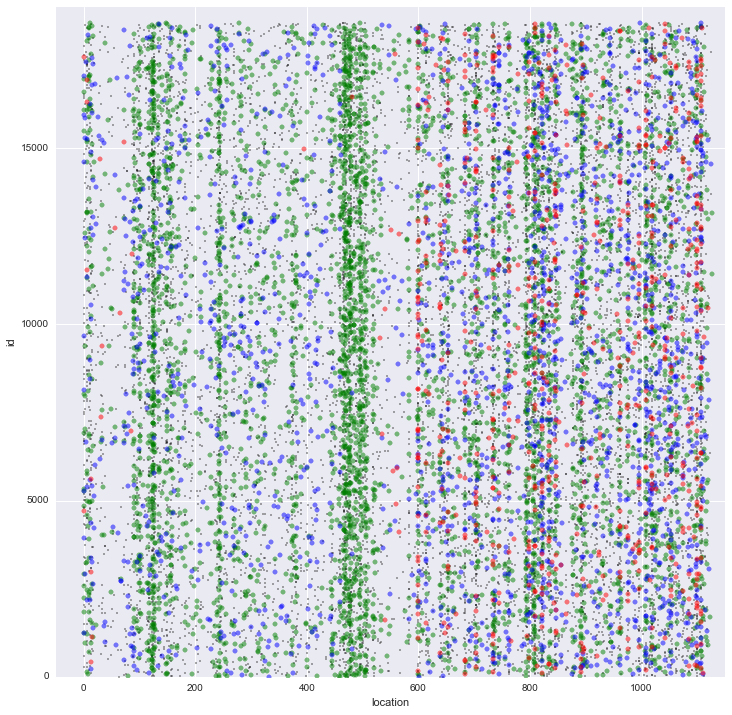

In [4]:
fig, ax = plt.subplots(figsize=(12,12))
ax.scatter(df.loc[df.fault_severity == 'predict!', 'location'], df.loc[df.fault_severity == 'predict!'].index, alpha=0.5, color='k', s=2)
ax.scatter(df.loc[df.fault_severity == 0, 'location'], df.loc[df.fault_severity == 0].index, alpha=0.5, color='g')
ax.scatter(df.loc[df.fault_severity==1,'location'], df.loc[df.fault_severity==1].index, alpha=0.5, color='b')
ax.scatter(df.loc[df.fault_severity==2,'location'], df.loc[df.fault_severity==2].index, alpha=0.5, color='r')
ax.set_xlim((-50,1150))
ax.set_ylim((0,19000))
ax.set_xlabel('location')
ax.set_ylabel('id');

Location does not appear to be a completely independant feature - there are ranges within which the location variable acts similar to its neighbours. Therefore treating each location as a separate categorical feature is probably not the best way to go. Changing location from a sparse to a numerical feature in our simple model improves our mlogloss score to ~ 0.51279 (Places 293rd)

I failed to find a better use of the location variable but there appears to be a method able to do this - discussion of dune_dwellers approach: https://www.kaggle.com/c/telstra-recruiting-network/forums/t/19239/it-s-been-fun-post-your-code-github-links-here-after-the-competition/110104#post110104). She states her improvement was very small, only 0.0008 mlogloss.

There does not appear to be any usefulness to the id value, which is expected.

# Magic Feature 

After noticing a large gap in leaderboard scores and discussions of a 'magic feature' on the forums, I went back to carefully read the description of the competition to search for clues. This portion immediately caught my eye:

"Each row in the main dataset (train.csv, test.csv) represents a location and a time point. They are identified by the "id" column, which is the key "id" used in other data files."

But this time variable was not explicitely given in any of the data sets and so I thought about ways in which they could hide this information. Some ideas I had and tested were:
    - number of events / resources / log features per id
    - order that events / resources / log features were given inside each id
    - order of id in train / test data sets
    - order of id inside severity / event / log feature / resource data sets (order is the same in all these)
    
It was this last idea that yielded promising results:

In [5]:
# Severity type data - one entry per id
severity_type = pd.read_csv('severity_type.csv')
severity_type['severity_type'] = severity_type['severity_type'].apply(lambda x: int(x.split('severity_type ')[1]))
id_order = severity_type.loc[:, 'id'].values
ordered_data = df.reindex(id_order)
print ordered_data.iloc[0:50]

      fault_severity  location
id                            
6597        predict!         1
8011               0         1
2597        predict!         1
5022        predict!         1
6852        predict!         1
5611        predict!         1
14838       predict!         1
2588               0         1
4848               0         1
6914               0         1
5337               0         1
10460       predict!         1
15494              0         1
10289       predict!         1
8587        predict!         1
12943       predict!         1
590         predict!         1
16416       predict!         1
3399        predict!         1
1505        predict!         1
9446        predict!         1
12482       predict!         1
16538       predict!         1
2250               0         1
5259               0         1
12751       predict!         1
5195        predict!         1
1233        predict!         1
4703               2         1
17508       predict!         1
6008    

The first thing of note is that the location variable is already ordered with this id ordering. The other pattern wasn't immediately obvious, but after scrolling down through hundreds of rows of data I began to notice a non-random behaviour in fault_severity.

It is more clearly seen within larger locations:

In [6]:
ordered_data.loc[(ordered_data.location == 821) & (ordered_data.fault_severity != 'predict!'), 'fault_severity']

id
486      0
18055    0
10475    0
10404    0
698      0
4960     0
7350     0
11262    0
11174    0
4493     0
15915    0
67       0
3215     0
8617     0
4813     0
18536    0
13728    0
16866    1
18061    1
8163     2
7295     1
3571     1
16700    2
6162     2
452      1
3943     1
3136     2
16491    2
9996     2
11472    0
        ..
2524     2
10664    2
13004    0
18313    1
5497     2
16577    2
14249    2
15144    2
4271     1
3097     2
6225     1
752      1
5387     2
11765    1
7035     2
3501     1
15860    1
5472     0
12782    2
14127    1
11939    1
11612    0
7126     2
2114     1
7268     1
1746     2
5556     1
14232    0
5232     2
2380     1
Name: fault_severity, dtype: object

In [7]:
loc821_train = ordered_data.loc[(ordered_data.location == 821) & (ordered_data.fault_severity != 'predict!')]
print 'Average fault severity in loc 821:', loc821_train.fault_severity.sum() / len(loc821_train)

Average fault severity in loc 821: 0.976470588235


With this ordering, do the first id's within each location have a high chance of mapping to fault_severity 0?

In [8]:
ordered_data['intra-location num'] = ordered_data.groupby('location').cumcount()
ordered_data['intra-location fraction'] = ordered_data.groupby('location')['intra-location num'].apply(lambda x: (x + 0.5) / (x.max() + 1))
ordered_data.head(150)

,fault_severity,location,intra-location num,intra-location fraction
id,,,,
6597,predict!,1,0,0.007246
8011,0,1,1,0.021739
2597,predict!,1,2,0.036232
5022,predict!,1,3,0.050725
6852,predict!,1,4,0.065217
5611,predict!,1,5,0.079710
14838,predict!,1,6,0.094203
2588,0,1,7,0.108696
4848,0,1,8,0.123188


Again, dune_dweller has created a nice visualization of this new features power:

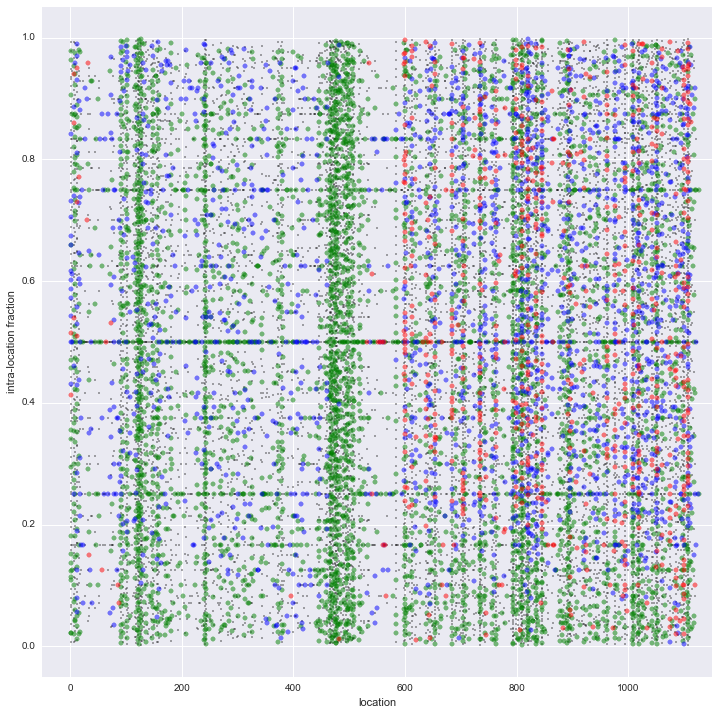

In [9]:
fig, ax = plt.subplots(figsize=(12,12))
ax.scatter(ordered_data.loc[ordered_data.fault_severity == 'predict!', 'location'], ordered_data.loc[ordered_data.fault_severity == 'predict!', 'intra-location fraction'], alpha = 0.5, color = 'k', s=2)
ax.scatter(ordered_data.loc[ordered_data.fault_severity == 0, 'location'], ordered_data.loc[ordered_data.fault_severity == 0, 'intra-location fraction'], alpha = 0.5, color = 'g')
ax.scatter(ordered_data.loc[ordered_data.fault_severity == 1, 'location'], ordered_data.loc[ordered_data.fault_severity == 1,'intra-location fraction'], alpha = 0.5, color = 'b')
ax.scatter(ordered_data.loc[ordered_data.fault_severity == 2, 'location'], ordered_data.loc[ordered_data.fault_severity == 2,'intra-location fraction'], alpha = 0.5, color = 'r')
ax.set_xlim((-50,1150))
ax.set_ylim((-.05,1.05))
ax.set_xlabel('location')
ax.set_ylabel('intra-location fraction');

In the lower right of this image, there appears to be a strong relationship between intra-location fraction and fault_severity. Adding this feature to our simple model (with numerical location) achieves a score of ~ 0.44809 (places 71st).

# Further Exploration
I spent a long time trying to find relationships between the other features (event type / resource type / log feature / severity type)

It was useful to put the data in a non-sparse form:

In [10]:
# Event type data
event_type = pd.read_csv('Event_type.csv')
event_type['event_type'] = event_type['event_type'].apply(lambda x: int(x.split('event_type ')[1]))
event_type_list = pd.DataFrame(event_type.groupby(['id'])['event_type'].apply(list)) # groupby sorts by the variable its grouped on
event_type_list['event_type'] = event_type_list['event_type'].apply(lambda x: sorted(x))
event_type_list.head(4)

,event_type
id,
1,"[11, 13]"
2,"[34, 35]"
3,[11]
4,[47]


In [11]:
# Log feature data
log_feature = pd.read_csv('log_feature.csv')
log_feature['log_feature'] = log_feature['log_feature'].apply(lambda x: int(x.split('feature ')[1]))
log_feature['volume'] = log_feature['volume'].apply(lambda x: int(x))
log_feature.sort_values(['id', 'log_feature'], inplace = True) # Loss of information, but I checked and order doesnt matter
log_feature_list = pd.concat([log_feature.groupby(['id'])['log_feature'].apply(list), log_feature.groupby(['id'])['volume'].apply(list)], axis = 1)
log_feature_list.head(4)

,log_feature,volume
id,,
1,"[68, 179, 345]","[2, 1, 2]"
2,"[233, 235, 312, 313, 315]","[1, 1, 1, 1, 1]"
3,[171],[2]
4,[370],[3]


In [12]:
# Resource type data
resource_type = pd.read_csv('resource_type.csv')
resource_type['resource_type'] = resource_type['resource_type'].apply(lambda x: int(x.split('resource_type ')[1]))
resource_type_list = pd.DataFrame(resource_type.groupby(['id'])['resource_type'].apply(list))
resource_type_list['resource_type'] = resource_type_list['resource_type'].apply(lambda x: sorted(x))

# Severity type data - one entry per id
severity_type = pd.read_csv('severity_type.csv')
severity_type['severity_type'] = severity_type['severity_type'].apply(lambda x: int(x.split('severity_type ')[1]))
severity_type_list = pd.DataFrame(severity_type.groupby(['id'])['severity_type'].apply(list))

# Concat all data into one pandas data frame
merge_data = pd.concat([df, event_type_list, resource_type_list, severity_type_list, log_feature_list], axis = 1)
merge_data.head(5)

,fault_severity,location,event_type,resource_type,severity_type,log_feature,volume
id,,,,,,,
1,1,601,"[11, 13]","[6, 8]",[1],"[68, 179, 345]","[2, 1, 2]"
2,predict!,474,"[34, 35]",[2],[2],"[233, 235, 312, 313, 315]","[1, 1, 1, 1, 1]"
3,predict!,64,[11],[8],[1],[171],[2]
4,predict!,645,[47],[2],[4],[370],[3]
5,0,460,"[34, 35]",[2],[2],"[232, 312]","[6, 11]"


Looking at specific slices of data

id's with event_type 11:

In [13]:
sparse_data = pd.read_csv('simple.csv', index_col = 'id')
event_11_indices = sparse_data.loc[sparse_data['e_11'] == 1].index.values
merge_data.loc[merge_data.index.isin(event_11_indices)].head(100)

,fault_severity,location,event_type,resource_type,severity_type,log_feature,volume
id,,,,,,,
1,1,601,"[11, 13]","[6, 8]",[1],"[68, 179, 345]","[2, 1, 2]"
3,predict!,64,[11],[8],[1],[171],[2]
9,predict!,1100,"[11, 15]",[8],[1],"[56, 82, 105, 172, 203]","[213, 15, 33, 158, 2]"
10,predict!,878,[11],[8],[1],"[73, 195]","[5, 5]"
16,predict!,831,[11],[8],[1],[54],[1]
20,0,79,"[10, 11, 54]","[2, 3, 8]",[2],"[39, 55]","[1, 1]"
21,predict!,826,"[11, 13, 14]","[4, 6, 8]",[1],"[54, 68, 170, 273]","[4, 2, 4, 2]"
25,predict!,1112,[11],[8],[2],[206],[1]
27,0,793,[11],[8],[1],"[73, 195]","[3, 2]"


Every id with event_type 11 also has resource_type 8. In fact, for every event_type except one there is a similar mapping (there is one event type that can lead to one of two resource types).

After finding a similar mapping of log_feature to event_type I thought I definitely had found something that could improve my score.

For each log feature which only ever mapped to only one event_type, I would remove that reduntant information (event_type). For each log feature that mapped to one of two event_types, I would create a new feature column to indicate if it mapped to one or the other. For the event_type that mapped to one of two resource types I did the same. 

I hoped I was giving the machine new information with this process but unfortunately found no improvement in my scores. There is a discussion about this on the forums - apparently this is the type of learning that xgboost is already very good at learning, and it had figured out and was using these relationship when the data was in its simple sparse state.

# Room for improvement

- Better feature creation. Some interesting discussions on the forums about other features people used:
    - https://www.kaggle.com/c/telstra-recruiting-network/forums/t/19239/it-s-been-fun-post-your-code-github-links-here-after-the-competition/109814#post109814
    - https://www.kaggle.com/c/telstra-recruiting-network/forums/t/19239/it-s-been-fun-post-your-code-github-links-here-after-the-competition/109850#post109850

- Ensembling with random forest, neural nets, extra trees, etc (extra trees / xgboost ensembles scored very well)
- Stacking